<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit8/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a way to make predictions by asking a series of yes-or-no questions. It starts at the top with one big question and splits the data into two groups based on the answer. Each split leads to more questions until it gets to the end points, or “leaves,” where the final answers or predictions are made.

In the case of numbers, the tree checks things "like is this value smaller than that one?” to help sort the data into smaller chunks. For predicting something like octopus beak weight, the tree looks at upper beak length and keeps splitting the data to make better guesses.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is the number of layers or levels it has from the starting point (the root) down to the furthest leaf. It shows how many decisions the tree makes before it gives a final answer.

If a tree is too deep, it might learn tiny details or random noise in the training data, which makes it less accurate on new data ie overfitting. On the other hand, if the tree is too shallow, it might miss important patterns ie underfitting.

**Task4:**

How are BART models similar and different from a decision tree?

BART (Bayesian Additive Regression Trees) models are built using lots of small decision trees, kind of like in a random forest. But while random forests usually grow many deep trees independently, BART does things a bit differently.

In BART, the trees work together as a team with each one trying to fix the mistakes made by the others. 

Also, BART keeps its trees small and simple by using something regularization. This just means the model prefers shallow trees so it doesn’t overcomplicate things or go too far from the actual data. That helps BART avoid overfitting and stay focused on patterns that really matter.

So in essence, BART uses decision trees like a random forest does, but the trees are smaller, work together more closely, and are regularizaed to make better predictions.

**Task5**:

Why would we use a BART model instead of a decision tree?

When we care more about accuracy and capturing uncertainty than just speed.

Decision trees are fast and easy to understand, but they can miss important patterns (underfitting) or get too caught up in the noise (overfitting). They also give just one best guess and don’t show how uncertain that guess might be ie they skip over the variation to keep things quick.

BART, on the other hand, takes more time to run, but it’s much more careful. It uses many small trees that work together, and it includes methods like boosting to catch more patterns and regularization to avoid overfitting. It also uses MCMC (a type of Bayesian sampling) to show how confident it is in its predictions.

So, while a single decision tree is faster, BART gives you better predictions and includes useful information about uncertainty.

## Bartian Penguins

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [2]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [3]:
clmn_list = ['species',
             'island',
             'bill_length',
             'bill_depth',
             'flipper_length',
             'body_mass',
             'sex',
             'year'
            ]
penguin_stats =  penguins.loc[:,clmn_list]
penguin_stats =  penguins.loc[:,clmn_list]
penguin_stats_nona = penguin_stats.dropna()
penguin_stats.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


In [4]:
X = penguin_stats_nona[[
             'flipper_length', 
             'bill_depth',
             'bill_length']]
Y = penguin_stats_nona["body_mass"].to_numpy()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 449 seconds.
Sampling: [y]


Output()

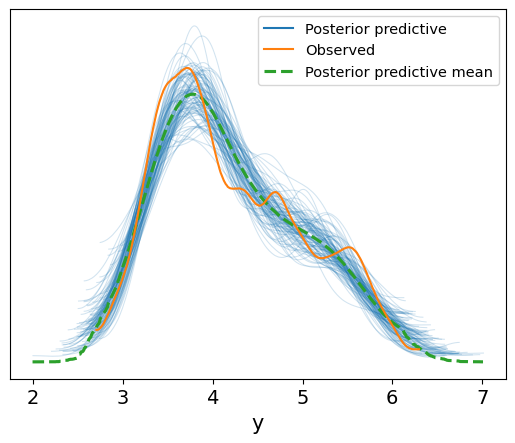

In [5]:
with pm.Model() as model_penguins:
    s = pm.Normal("s", mu = 3.5, sigma = .5) #these are just blind guesses
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50) #log around Y
    μ = pm.Deterministic("μ",pm.math.exp(μ_)) #exp it all once BART is done
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y) #likelihood
    idata_penguins = pm.sample(compute_convergence_checks=False)

pm.sample_posterior_predictive(idata_penguins,model_penguins, extend_inferencedata=True)
ax = az.plot_ppc(idata_penguins, num_pp_samples=100, colors=["C0", "C1", "C2"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

<Axes: xlabel='flipper_length', ylabel='body_mass'>

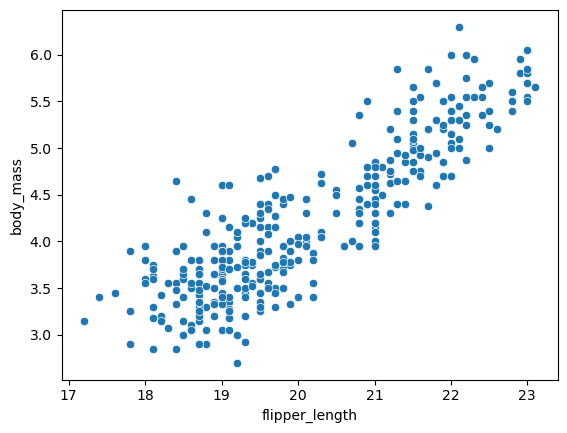

In [6]:
sns.scatterplot(data = penguin_stats_nona, y = 'body_mass', x = 'flipper_length')

In [7]:
posterior_mean = idata_penguins.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguins, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_penguins, group="posterior_predictive", var_names=["y"]
).T

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\plots\hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


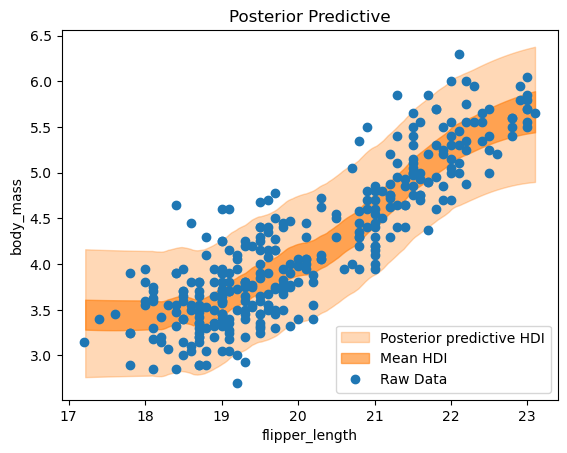

In [8]:
idx = np.argsort(X.to_numpy()[:, 0]) #grab fifth row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 0],#grab fifth row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguin_stats_nona['flipper_length'], penguin_stats_nona["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

The mean prediction clearly shows a positive association between the two variables: as flipper length increases, predicted body mass also increases. Most of the raw data fall within posterior predictive HDI, suggesting that the model is doing a good job accounting for the variation in the observed data. The band is wider in areas where the data are more variable (around flipper lengths of 18–19 cm) and narrower where the data are denser and more consistent (21–22 cm), indicating that the model adjusts its confidence based on data density. There are some areas, particularly at the higher end of flipper length (22–23 cm), where the model slightly underpredicts body mass, as several points lie above the HDI. Similarly, the spread in body mass for shorter flipper lengths appears larger than the model expects. This is probably because the model doesn't want to overfit so overall the model generally captures the relationship well.








**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

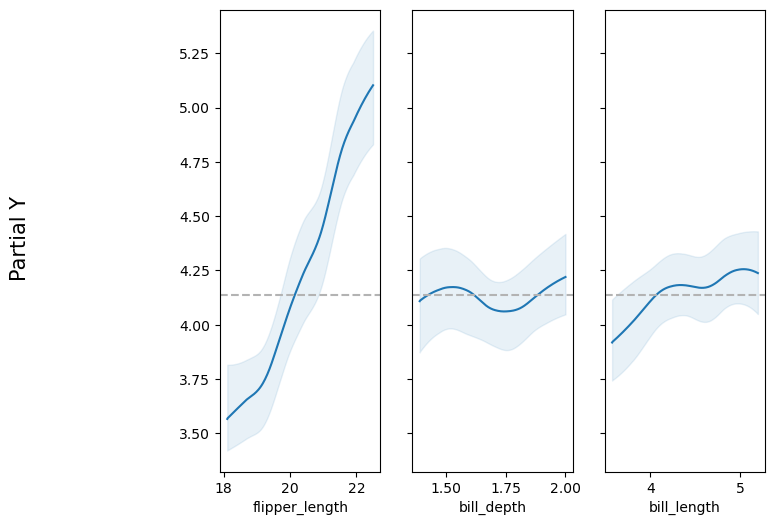

In [9]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='bill_length'>], dtype=object)

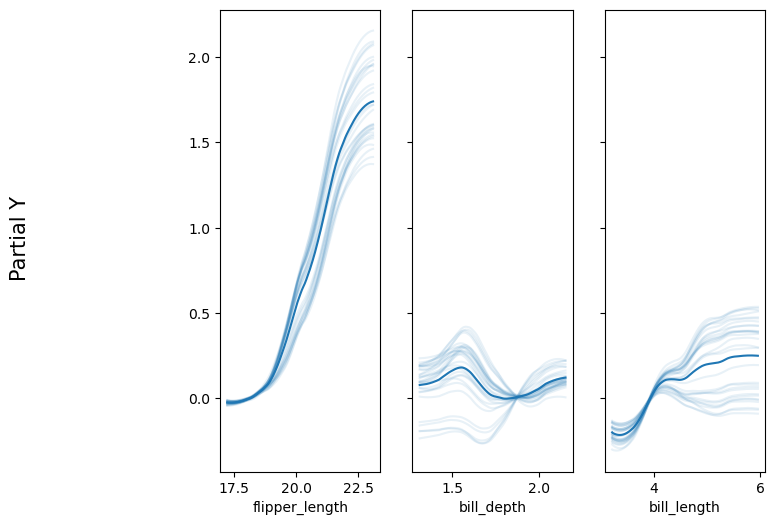

In [10]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

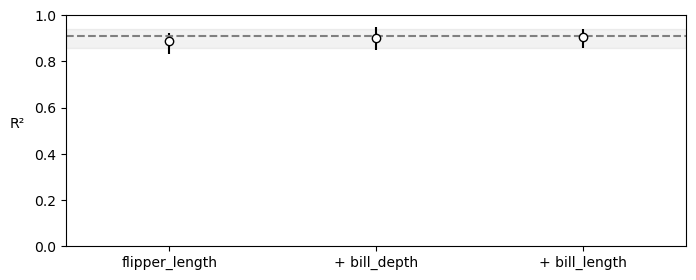

In [11]:
vi_penguins = pmb.compute_variable_importance(idata_penguins, μ_, X)
pmb.plot_variable_importance(vi_penguins)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Flipper length is clearly the most important predictor of body mass in penguins. The variable importance plot shows that nearly all of the model’s explanatory power comes from flipper length, with R² remaining high even before adding bill depth and bill length. Adding those two variables results in only a slight increase in R², suggesting that they contribute relatively little information for predicting body mass once flipper length is already accounted for.

The PDPs also support this finding. The flipper length panel shows a strong, smooth upward trend, indicating a clear positive relationship with body mass. The shaded region around the line is fairly narrow, showing that the model is confident in this relationship. In contrast, the PDPs for bill depth and bill length are nearly flat, with wider uncertainty bands, suggesting these variables have a much weaker and more uncertain influence on body mass after accounting for flipper length.

The ICE plots also show this. For flipper length, almost all the individual lines show a consistent upward slope, which implies that the relationship holds across different penguins. For bill depth and bill length, however, the lines vary more in shape and direction, which tell me that their effects are less consistent and more influenced by noise.

There is no strong evidence of interactions between the variables and flipper length in these plots as for flipper length, the lines remain roughly parallel. This suggests that flipper length has a stable and dominant effect on body mass. For the other variables, especially bill depth, you can see how the lines cross and the lack of parallel. In beginning of bill length we see a similar trend. 
